# Trabajo práctico nº4 - Grünewald, Martina
---

In [9]:
import sys
import os
ROOT_DIR = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(ROOT_DIR)
sys.path.append('../notebooks/')

from src.preprocesing import handle_missing_values, numerize, normalize
from src. data_splitting import train_val_split, split_k_folds
from src. metrics import rmse, r2, mae, mse
from src. lr_decay import linear_decay_lr, power_law_lr, exponential_decay_lr
from src.models.model_1 import MLP
from src.models.model_2 import MLP_L2
from src.models.model_3 import MLP_OPT
from src.models.modelos_TP2 import RidgeRegression, NonLinearRegression, LocallyWeightedRegression

import pandas as pd
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

---
# Ejercicio 1
### Implementar la red neuronal multi-capa

In [10]:
archivo = '../data/procesed/procesado_completo.csv'
data = pd.read_csv(archivo)
raw_data = data.drop(columns=['id'])
raw_data = data.drop(columns=['Color'])
datos_curados = handle_missing_values(raw_data)

X = datos_curados.iloc[:, :-1]  
y = datos_curados.iloc[:, -1]  
X = numerize(X)
X = normalize(X)
datos_procesados = pd.concat([X, y], axis=1)
entrenamiento, validacion = train_val_split(datos_procesados, 0.8)

X_train = entrenamiento.iloc[:, :-1].values
y_train = entrenamiento.iloc[:, -1].values
training_data = [(x.reshape(-1, 1), np.array([y]).reshape(-1, 1)) for x, y in zip(X_train, y_train)] #Convierto a lista de tuplas 

X_val = validacion.iloc[:, :-1].values
y_val = validacion.iloc[:, -1].values
validation_data = [(x.reshape(-1, 1), np.array([y]).reshape(-1, 1)) for x, y in zip(X_val, y_val)] #Convierto a lista de tuplas 


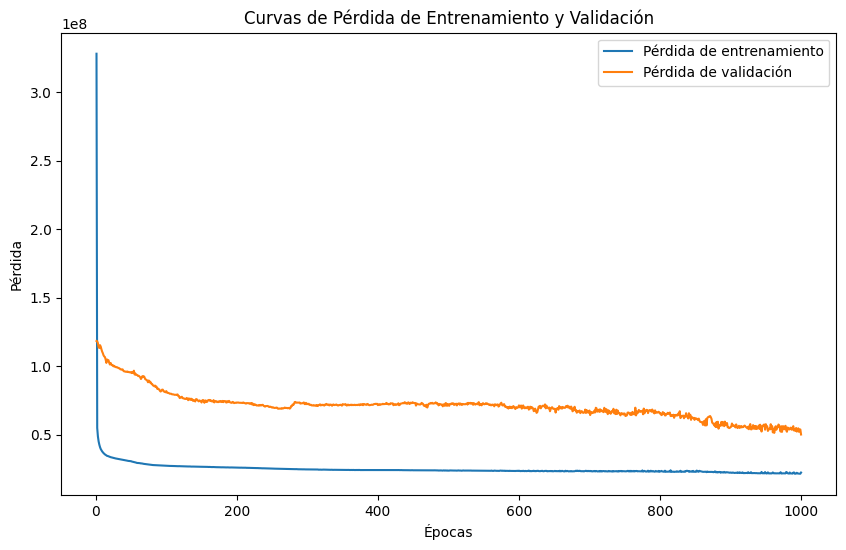

          RMSE          MAE       R2
0  7083.492804  5530.596578  0.71125


In [36]:
mlp = MLP(layers=[X_train.shape[1], 10, 8, 4, 1], activations=['relu', 'relu', 'relu', 'relu'], verbose=True, plot=True)
lr = 1e-8  
epochs = 1000

train_losses = []
val_losses = []

for epoch in range(epochs):
    total_loss = 0
    for x, y in training_data:
        delta_nabla_b, delta_nabla_w, loss = mlp.backward_pass(*mlp.forward_pass(x), y)
        mlp.weights = [w - lr * nw for w, nw in zip(mlp.weights, delta_nabla_w)]
        mlp.biases = [b - lr * nb for b, nb in zip(mlp.biases, delta_nabla_b)]
        total_loss += loss

    avg_train_loss = total_loss / len(training_data)
    train_losses.append(avg_train_loss)
    val_loss = mlp.evaluate(validation_data)
    val_losses.append(val_loss)

plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs + 1), train_losses, label='Pérdida de entrenamiento')
plt.plot(range(1, epochs + 1), val_losses, label='Pérdida de validación')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.title('Curvas de Pérdida de Entrenamiento y Validación')
plt.legend()
plt.show()

y_pred = []
for x in X_val:
    _, z = mlp.forward_pass(x.reshape(-1, 1)) 
    y_pred.append(z[-1]) 
y_pred = np.array(y_pred).flatten()

metrics_results = {
    "RMSE": rmse(y_val, y_pred),
    "MAE": mae(y_val, y_pred),
    "R2": r2(y_val, y_pred)
}
metrics_df = pd.DataFrame(metrics_results, index=[0])
print(metrics_df)


#### Como es de esperar, el la pérdida con el conjunto de entrenamiento es menor que la pérdida de validación. La training loss disminuye mucho al principio, demostrando que está aprendiendo a partir de los datos de entrenamiento hasta encontrar estabilidad. Ambas parecen disminuir con el pasar de las epochs, pero la pérdida en la validación no llega a puntos muy bajos de golpe, mostrando que no esta sobreajustando.

#### Los resultados de las métricas son razonables pero mejorables. 

---
# Ejercicio 2
### Implementar un Learning Rate Scheduler

  0%|          | 0/50 [00:00<?, ?it/s]

100%|██████████| 50/50 [00:52<00:00,  1.05s/it]


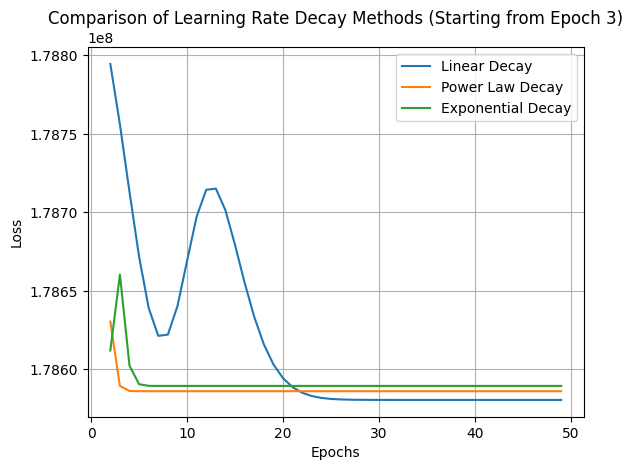

In [41]:
def train_with_decay(model, training_data, initial_lr, epochs, decay_function):
    loss_history = []
    lr = initial_lr
    
    for epoch in tqdm(range(epochs)):
        if decay_function == 1:
            lr = linear_decay_lr(lr, epoch, epochs)
        elif decay_function == 2:
            lr = power_law_lr(lr, epoch, p=2)
        elif decay_function == 3:
            lr = exponential_decay_lr(lr, epoch, decay_rate=0.5)
        total_loss = 0
        
        for x, y in training_data:
            delta_nabla_b, delta_nabla_w, loss = model.backward_pass(*model.forward_pass(x), y)
            model.weights = [w - lr * nw for w, nw in zip(model.weights, delta_nabla_w)]
            model.biases = [b - lr * nb for b, nb in zip(model.biases, delta_nabla_b)]
            total_loss += loss
        
        avg_train_loss = total_loss / len(training_data)
        loss_history.append(avg_train_loss)

    return loss_history

model = MLP(layers=[X_train.shape[1], 10, 8, 4, 1], activations=['relu', 'relu', 'relu', 'relu'], verbose=0, plot=False)

initial_lr = 1e-2
epochs = 50
training_data = list(zip(X_train, y_train))

history_linear = train_with_decay(model, training_data, initial_lr, epochs, 1)  # Linear decay
history_power = train_with_decay(model, training_data, initial_lr, epochs, 2)   # Power law decay
history_exponential = train_with_decay(model, training_data, initial_lr, epochs, 3)  # Exponential decay

plt.plot(range(2, epochs), history_linear[2:], label="Linear Decay")
plt.plot(range(2, epochs), history_power[2:], label="Power Law Decay")
plt.plot(range(2, epochs), history_exponential[2:], label="Exponential Decay")
plt.title("Comparison of Learning Rate Decay Methods (Starting from Epoch 3)")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()


#### Es posible visualizar que a pesar de empezar con una mayor pérdida, el Linear Decay es el que menor pérdida tiene con el pasar de las epochs. El que utiliza Power Law Decay para modificar el learning rate es el que más rápido decae y encuentra estabilización, pero no es el que menor pérdida tiene.

---
# Ejercicio 3
### Implementar Regularización L2

Training Epochs: 100%|██████████| 150/150 [01:50<00:00,  1.36it/s]


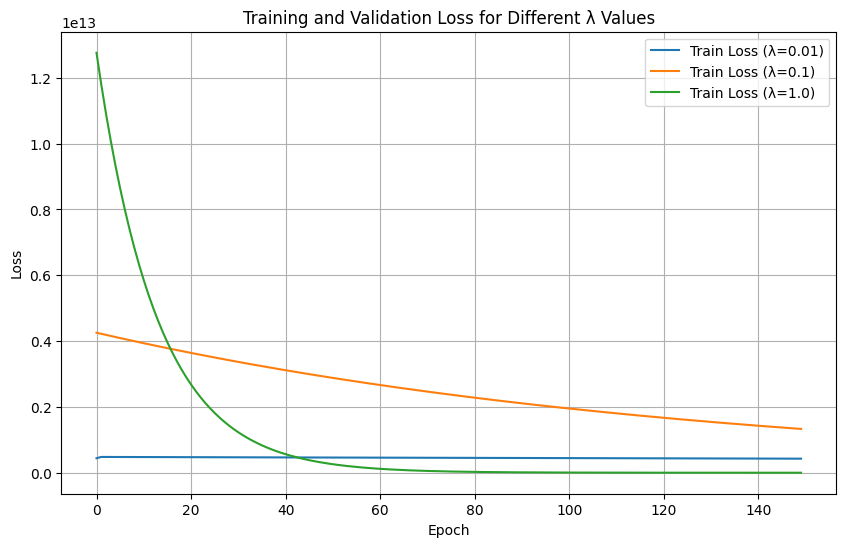

{0.01: ([np.float64(440359615251.3674),
   np.float64(479781944520.2961),
   np.float64(479335950978.3675),
   np.float64(478954064765.6204),
   np.float64(478579578944.34247),
   np.float64(478207418540.0622),
   np.float64(477834494424.08514),
   np.float64(477461370840.0808),
   np.float64(477089170702.16925),
   np.float64(476718623628.3749),
   np.float64(476345981090.688),
   np.float64(475975955572.1395),
   np.float64(475605359505.0214),
   np.float64(475232753381.35376),
   np.float64(474862660632.0573),
   np.float64(474492415840.01715),
   np.float64(474123042638.1352),
   np.float64(473752633706.1753),
   np.float64(473384066151.8688),
   np.float64(473014707001.2627),
   np.float64(472646652254.6119),
   np.float64(472278567314.7448),
   np.float64(471911163928.9233),
   np.float64(471543515396.84686),
   np.float64(471173886149.3872),
   np.float64(470806957179.4616),
   np.float64(470441030105.76404),
   np.float64(470073435799.0475),
   np.float64(469706708986.64825),
 

In [40]:

mlp_l2 = MLP_L2(layers=[X_train.shape[1], 10, 8, 4, 1], activations=['relu', 'relu', 'relu', 'relu'], plot=True)
mlp_l2.fit_with_l2(training_data, epochs=150, mini_batch_size=32, lr=0.001, val_data=validation_data, lambdas=[0.01, 0.1, 1.0], verbose=0)

#### Como sucedía en el caso anterior, aún si en el comienzo es el que mayor pérdida tiene, el modelo regulado con lambda=1 es el que a la larga tiene menor pérdida. 

In [5]:
predictions_dict = {}
metrics_dict = {}

def train_and_evaluate(mlp, lambda_value, training_data, X_val, y_val, epochs=100, lr=0.01, mini_batch_size=64):
    mlp.l2_lambda = lambda_value
    print(f"Entrenando con lambda = {lambda_value}...")
    mlp.fit(training_data, epochs=epochs, mini_batch_size=mini_batch_size, lr=lr, val_data=None, verbose=1)
    predictions = mlp.predict(X_val)
    metrics_results = {        
        "RMSE": rmse(y_val, predictions.flatten()),
        "MAE": mae(y_val, predictions.flatten()),
        "R2": r2(y_val, predictions.flatten())
    }
    return predictions, metrics_results

#lambda = 0.01
mlp_l2_1 = MLP_L2(layers=[X_train.shape[1], 10, 8, 4, 1], activations=['relu', 'relu', 'relu', 'relu'], plot=True)
predictions_l2_0_01, metrics_results_0_01 = train_and_evaluate(mlp_l2_1, 0.01, training_data, X_val, y_val, epochs=100, lr=0.01)
predictions_dict[0.01] = predictions_l2_0_01
metrics_dict[0.01] = metrics_results_0_01
print(f"Metrics for lambda 0.01:\n{metrics_results_0_01}")

#lambda = 0.1
mlp_l2_2 = MLP_L2(layers=[X_train.shape[1], 10, 8, 4, 1], activations=['relu', 'relu', 'relu', 'relu'], plot=True)
predictions_l2_0_1, metrics_results_0_1 = train_and_evaluate(mlp_l2_2, 0.1, training_data, X_val, y_val, epochs=100, lr=0.01)
predictions_dict[0.1] = predictions_l2_0_1
metrics_dict[0.1] = metrics_results_0_1
print(f"Metrics for lambda 0.1:\n{metrics_results_0_1}")

#lambda = 1.0
mlp_l2_3 = MLP_L2(layers=[X_train.shape[1], 10, 8, 4, 1], activations=['relu', 'relu', 'relu', 'relu'], plot=True)
predictions_l2_1_0, metrics_results_1_0 = train_and_evaluate(mlp_l2_3, 1.0, training_data, X_val, y_val, epochs=100, lr=0.01)
predictions_dict[1.0] = predictions_l2_1_0
metrics_dict[1.0] = metrics_results_1_0
print(f"Metrics for lambda 1.0:\n{metrics_results_1_0}")


Entrenando con lambda = 0.01...
Metrics for lambda 0.01:
{'RMSE': np.float64(11953.60639426127), 'MAE': np.float64(9343.445225520783), 'R2': np.float64(-0.0041792642465252605)}
Entrenando con lambda = 0.1...
Metrics for lambda 0.1:
{'RMSE': np.float64(36581.053578265935), 'MAE': np.float64(34581.490126708544), 'R2': np.float64(-8.404284640167207)}
Entrenando con lambda = 1.0...
Metrics for lambda 1.0:
{'RMSE': np.float64(11929.719032403447), 'MAE': np.float64(9336.215025482574), 'R2': np.float64(-0.0001698924488104936)}


#### Aún si las tres predicciónes no son buenas, el que mejor predice es el que entrena con lambda = 1.

---
# Ejercicio 4
### Implementar métodos de optimización

Aclaración: este ejercicio tiene un error que no se pudo solucionar con algunos optimizadores; los pesos no se actualizaban y los nabla se mantenían nulos. Se revisó el Bishop y se imprimieron los valores, pero no se pudo solucionar. Dado a que el optimizador Adam sí funciona correctalamente, los días gastados en este ejercicio y por el bien del trabajo se siguió adelante. Disculpas. 

Training Epochs:   0%|          | 0/1000 [00:00<?, ?it/s]

Training Epochs: 100%|██████████| 1000/1000 [02:31<00:00,  6.61it/s]


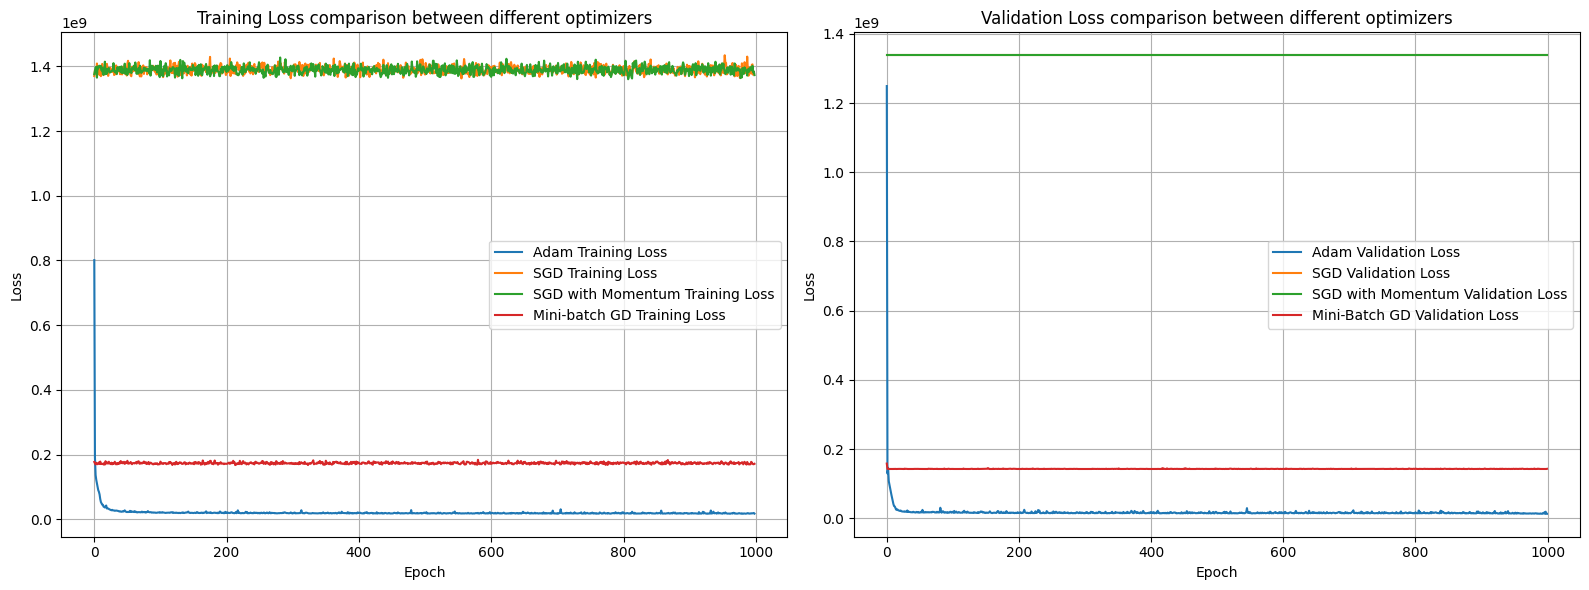

  Optimizador          RMSE           MAE        R2
0         SGD  36581.053578  34581.490127 -8.404285
         Optimizador          RMSE           MAE        R2
0  SGD with Momentum  36581.053578  34581.490127 -8.404285
     Optimizador          RMSE          MAE        R2
0  Mini-batch GD  11948.763013  9340.094859 -0.003366
  Optimizador         RMSE          MAE        R2
0        Adam  3578.120358  2543.796266  0.910025


In [11]:
mlp = MLP_OPT(layers=[X_train.shape[1], 10, 8, 4, 1], activations=['relu', 'relu', 'relu', 'relu'], verbose=False, plot=False)
sgd_losses, val_losses_sgd = mlp.fit(training_data, epochs=1000, mini_batch_size=64, lr=0.1, optimizer="sgd", val_data=validation_data, verbose=0)
sgd_predictions = mlp.predict(X_val)
mlp = MLP_OPT(layers=[X_train.shape[1], 10, 8, 4, 1], activations=['relu', 'relu', 'relu', 'relu'], verbose=False, plot=False)
momentum_losses, val_losses_momentum = mlp.fit(training_data, epochs=1000, mini_batch_size=64, lr=0.1, optimizer="momentum", val_data=validation_data, verbose=0)
momentum_predictions = mlp.predict(X_val)
mlp = MLP_OPT(layers=[X_train.shape[1], 10, 8, 4, 1], activations=['relu', 'relu', 'relu', 'relu'], verbose=False, plot=False)
mb_losses, val_losses_mb = mlp.fit(training_data, epochs=1000, mini_batch_size=64, lr=0.1, optimizer="mini-batch", val_data=validation_data, verbose=0)
mb_predictions = mlp.predict(X_val)
mlp = MLP_OPT(layers=[X_train.shape[1], 10, 8, 4, 1], activations=['relu', 'relu', 'relu', 'relu'], verbose=False, plot=False)
adam_losses, val_losses_adam = mlp.fit(training_data, epochs=1000, mini_batch_size=64, lr=0.1, optimizer="adam", val_data=validation_data, verbose=0)
adam_predictions = mlp.predict(X_val)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))
axes[0].plot(adam_losses[1:], label="Adam Training Loss")
axes[0].plot(sgd_losses[2:], label="SGD Training Loss")
axes[0].plot(momentum_losses[1:], label="SGD with Momentum Training Loss")
axes[0].plot(mb_losses[1:], label="Mini-batch GD Training Loss")
axes[0].set_title("Training Loss comparison between different optimizers")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")
axes[0].legend()
axes[0].grid(True)
axes[1].plot(val_losses_adam, label="Adam Validation Loss")
axes[1].plot(val_losses_sgd, label="SGD Validation Loss")
axes[1].plot(val_losses_momentum, label="SGD with Momentum Validation Loss")
axes[1].plot(val_losses_mb, label="Mini-Batch GD Validation Loss")
axes[1].set_title("Validation Loss comparison between different optimizers")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Loss")
axes[1].legend()
axes[1].grid(True)
plt.tight_layout()
plt.show()

predictions = [sgd_predictions, momentum_predictions, mb_predictions, adam_predictions]
titles = ['SGD', 'SGD with Momentum', 'Mini-batch GD', 'Adam']

for i in range(len(predictions)):
    predictions[i] = predictions[i].flatten()
    metrics_results = {        
        "Optimizador":      titles[i],
        "RMSE":             rmse(y_val, predictions[i]),
        "MAE":              mae(y_val, predictions[i]),
        "R2":               r2(y_val, predictions[i])
}
    metrics_df = pd.DataFrame(metrics_results, index=[0])
    print(metrics_df)

#### Se puede observar como es que Adam es el único que mejora su périda en ambos casos, esto se debe a que los otros modelos están teniendo un error en los pesos y gradientes y estan prediciendo todo 0; por eso tienen el mismo error. Pero en el caso del de mini-batch no tiene una disminución de la pérdida, pero esta es menor a las otras dos; esto es porque está clasificando mal, pero no con 0. Por eso su R2 es 0. Para el caso del que está optimizado con el método Adam, la pérdida de validación converge más lento que la de entrenamiento.  

Training Epochs: 100%|██████████| 100/100 [00:14<00:00,  6.72it/s]


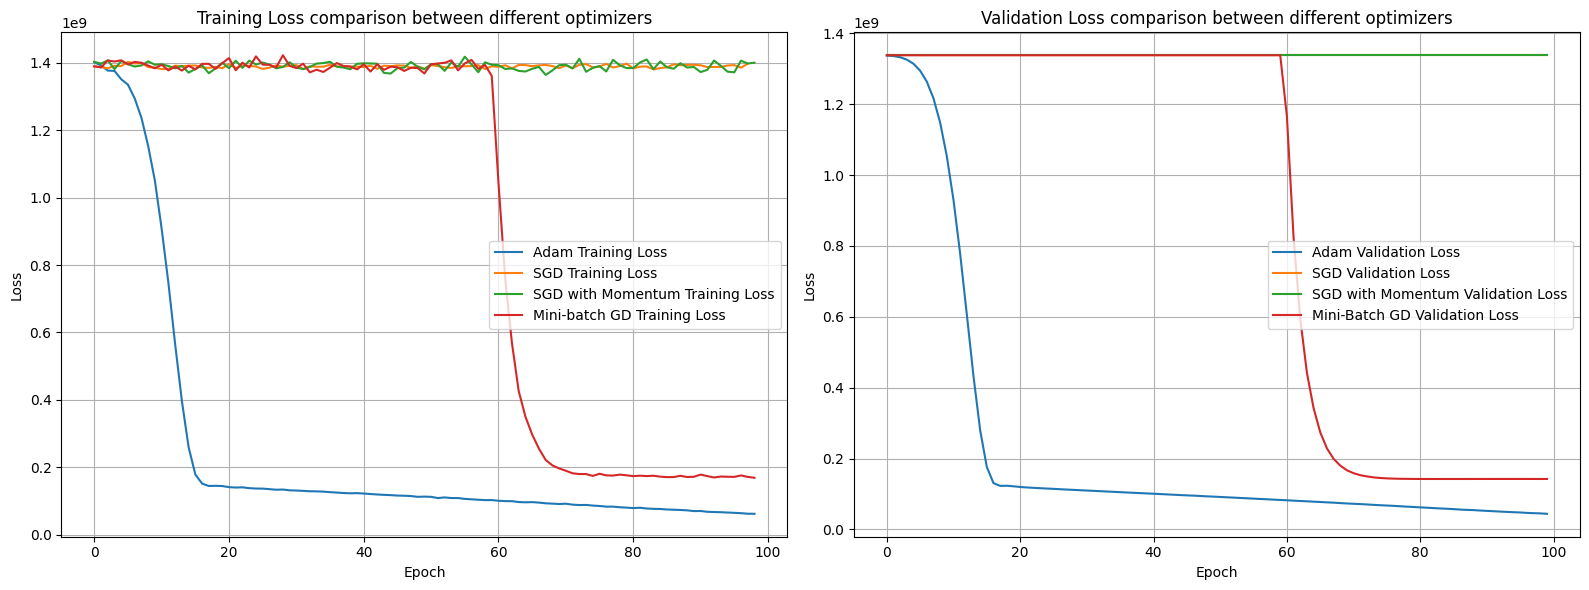

In [9]:
mlp = MLP_OPT(layers=[X_train.shape[1], 10, 8, 4, 1], activations=['relu', 'relu', 'relu', 'relu'], verbose=False, plot=False)
sgd_losses, val_losses_sgd = mlp.fit(training_data, epochs=100, mini_batch_size=32, lr=0.01, optimizer="sgd", val_data=validation_data, verbose=0)
sgd_predictions = mlp.predict(X_val)

mlp = MLP_OPT(layers=[X_train.shape[1], 10, 8, 4, 1], activations=['relu', 'relu', 'relu', 'relu'], verbose=False, plot=False)
momentum_losses, val_losses_momentum = mlp.fit(training_data, epochs=100, mini_batch_size=64, lr=0.01, optimizer="momentum", val_data=validation_data, verbose=0)
momentum_predictions = mlp.predict(X_val)

mlp = MLP_OPT(layers=[X_train.shape[1], 10, 8, 4, 1], activations=['relu', 'relu', 'relu', 'relu'], verbose=False, plot=False)
mb_losses, val_losses_mb = mlp.fit(training_data, epochs=100, mini_batch_size=64, lr=0.01, optimizer="mini-batch", val_data=validation_data, verbose=0)
mb_predictions = mlp.predict(X_val)

mlp = MLP_OPT(layers=[X_train.shape[1], 10, 8, 4, 1], activations=['relu', 'relu', 'relu', 'relu'], verbose=False, plot=False)
adam_losses, val_losses_adam = mlp.fit(training_data, epochs=100, mini_batch_size=128, lr=0.01, optimizer="adam", val_data=validation_data, verbose=0)
adam_predictions = mlp.predict(X_val)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))
axes[0].plot(adam_losses[1:], label="Adam Training Loss")
axes[0].plot(sgd_losses[2:], label="SGD Training Loss")
axes[0].plot(momentum_losses[1:], label="SGD with Momentum Training Loss")
axes[0].plot(mb_losses[1:], label="Mini-batch GD Training Loss")
axes[0].set_title("Training Loss comparison between different optimizers")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")
axes[0].legend()
axes[0].grid(True)
axes[1].plot(val_losses_adam, label="Adam Validation Loss")
axes[1].plot(val_losses_sgd, label="SGD Validation Loss")
axes[1].plot(val_losses_momentum, label="SGD with Momentum Validation Loss")
axes[1].plot(val_losses_mb, label="Mini-Batch GD Validation Loss")
axes[1].set_title("Validation Loss comparison between different optimizers")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Loss")
axes[1].legend()
axes[1].grid(True)
plt.tight_layout()
plt.show()

Aqui se ve mejor el cambio de aprendizaje del mini-batch. Aún si está prediciendo siempre lo mismo, no es 0.

### Dado a que solo se puede ver que el modelo con Adam mejora, se buscarán los mejores hiperparámetros para este.

## Hiperparámetros para Adam
#### Para el caso de Adam se realizaron diferentes modelos con diferentes hiperparámetros para visualizar el desempeño de cada uno

In [28]:
mlp = MLP_OPT(layers=[X_train.shape[1], 10, 8, 4, 1], activations=['relu', 'relu', 'relu', 'relu'], verbose=False, plot=False)
adam_losses_1, val_losses_adam_1 = mlp.fit(training_data, epochs=100, mini_batch_size=64, lr=0.1, optimizer="adam", val_data=validation_data, verbose=0)
adam_predictions_1 = mlp.predict(X_val)

mlp = MLP_OPT(layers=[X_train.shape[1], 10, 8, 4, 1], activations=['relu', 'relu', 'relu', 'relu'], verbose=False, plot=False)
adam_losses_2, val_losses_adam_2 = mlp.fit(training_data, epochs=100, mini_batch_size=64, lr=0.01, optimizer="adam", val_data=validation_data, verbose=0)
adam_predictions_2 = mlp.predict(X_val)

mlp = MLP_OPT(layers=[X_train.shape[1], 10, 8, 4, 1], activations=['relu', 'relu', 'relu', 'relu'], verbose=False, plot=False)
adam_losses_3, val_losses_adam_3 = mlp.fit(training_data, epochs=100, mini_batch_size=128, lr=0.1, optimizer="adam", val_data=validation_data, verbose=0)
adam_predictions_3 = mlp.predict(X_val)

mlp = MLP_OPT(layers=[X_train.shape[1], 10, 8, 4, 1], activations=['relu', 'relu', 'relu', 'relu'], verbose=False, plot=False)
adam_losses_4, val_losses_adam_4 = mlp.fit(training_data, epochs=100, mini_batch_size=128, lr=0.01, optimizer="adam", val_data=validation_data, verbose=0)
adam_predictions_4 = mlp.predict(X_val)

mlp = MLP_OPT(layers=[X_train.shape[1], 10, 8, 4, 1], activations=['relu', 'relu', 'relu', 'relu'], verbose=False, plot=False)
adam_losses_5, val_losses_adam_5 = mlp.fit(training_data, epochs=100, mini_batch_size=256, lr=0.1, optimizer="adam", val_data=validation_data, verbose=0)
adam_predictions_5 = mlp.predict(X_val)

mlp = MLP_OPT(layers=[X_train.shape[1], 10, 8, 4, 1], activations=['relu', 'relu', 'relu', 'relu'], verbose=False, plot=False)
adam_losses_6, val_losses_adam_6 = mlp.fit(training_data, epochs=100, mini_batch_size=256, lr=0.01, optimizer="adam", val_data=validation_data, verbose=0)
adam_predictions_6 = mlp.predict(X_val)

mlp = MLP_OPT(layers=[X_train.shape[1], 10, 8, 4, 1], activations=['relu', 'relu', 'relu', 'relu'], verbose=False, plot=False)
adam_losses_7, val_losses_adam_7 = mlp.fit(training_data, epochs=100, mini_batch_size=512, lr=0.1, optimizer="adam", val_data=validation_data, verbose=0)
adam_predictions_7 = mlp.predict(X_val)

mlp = MLP_OPT(layers=[X_train.shape[1], 10, 8, 4, 1], activations=['relu', 'relu', 'relu', 'relu'], verbose=False, plot=False)
adam_losses_8, val_losses_adam_8 = mlp.fit(training_data, epochs=100, mini_batch_size=512, lr=0.01, optimizer="adam", val_data=validation_data, verbose=0)
adam_predictions_8 = mlp.predict(X_val)


Training Epochs: 100%|██████████| 100/100 [00:46<00:00,  2.15it/s]


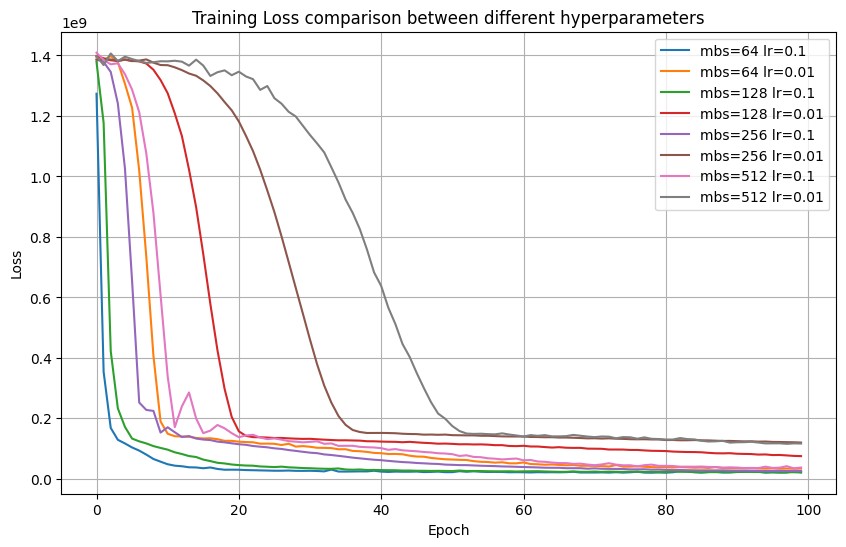

In [29]:
plt.figure(figsize=(10, 6))
plt.plot(adam_losses_1, label="mbs=64 lr=0.1")
plt.plot(adam_losses_2, label="mbs=64 lr=0.01")
plt.plot(adam_losses_3, label="mbs=128 lr=0.1")
plt.plot(adam_losses_4, label="mbs=128 lr=0.01")
plt.plot(adam_losses_5, label="mbs=256 lr=0.1")
plt.plot(adam_losses_6, label="mbs=256 lr=0.01")
plt.plot(adam_losses_7, label="mbs=512 lr=0.1")
plt.plot(adam_losses_8, label="mbs=512 lr=0.01")
plt.title("Training Loss comparison between different hyperparameters")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

#### Con solo observar las pérdidas, se ve que el modelo verde (el que usa Mini-batch size de 128 y un learning rate de 0.1), el azul (m-b size = 64 y lr = 0.1) y violeta (m-b size = 256 y lr = 0.1) son los que menos pérdida tienen para las epochs más grandes. Suponemos que estos modelos serán los que darán mejores resultados, 

In [30]:

predictions = [adam_predictions_1, adam_predictions_2, adam_predictions_3, adam_predictions_4, adam_predictions_5, adam_predictions_6, adam_predictions_7, adam_predictions_8]
titles = ['m-b size = 64 lr=0.1', 'm-b size = 64 lr=0.01', 'm-b size = 128 lr=0.1', 'm-b size = 128 lr=0.01', 'm-b size = 256 lr=0.1', 'm-b size = 256 lr=0.01', 'm-b size = 512 lr=0.1', 'm-b size = 512 lr=0.01']

for i in range(len(predictions)):
    predictions[i] = predictions[i].flatten()
    metrics_results = {        
        "Hiperparámetros":      titles[i],
        "RMSE":             rmse(y_val, (predictions[i])),
        "MAE":              mae(y_val, predictions[i]),
        "R2":               r2(y_val, predictions[i])
}
    metrics_df = pd.DataFrame(metrics_results, index=[0])
    print(metrics_df)

        Hiperparámetros         RMSE          MAE        R2
0  m-b size = 64 lr=0.1  4131.784833  2905.013179  0.880026
         Hiperparámetros         RMSE         MAE        R2
0  m-b size = 64 lr=0.01  4553.689932  3413.18588  0.854273
         Hiperparámetros         RMSE         MAE        R2
0  m-b size = 128 lr=0.1  4093.215459  2917.11814  0.882255
          Hiperparámetros         RMSE          MAE        R2
0  m-b size = 128 lr=0.01  7541.764232  5815.073502  0.600277
         Hiperparámetros         RMSE          MAE        R2
0  m-b size = 256 lr=0.1  4367.420444  3153.242819  0.865951
          Hiperparámetros         RMSE          MAE        R2
0  m-b size = 256 lr=0.01  9956.388579  7808.349801  0.303346
         Hiperparámetros         RMSE          MAE        R2
0  m-b size = 512 lr=0.1  4679.896241  3498.356017  0.846083
          Hiperparámetros        RMSE          MAE       R2
0  m-b size = 512 lr=0.01  9680.49702  7584.825851  0.34142


#### Efectivamente esos tres modelos fuerons los que tuvieron las mejores métricias de error a la hora de predecir con el conjunto de validación.

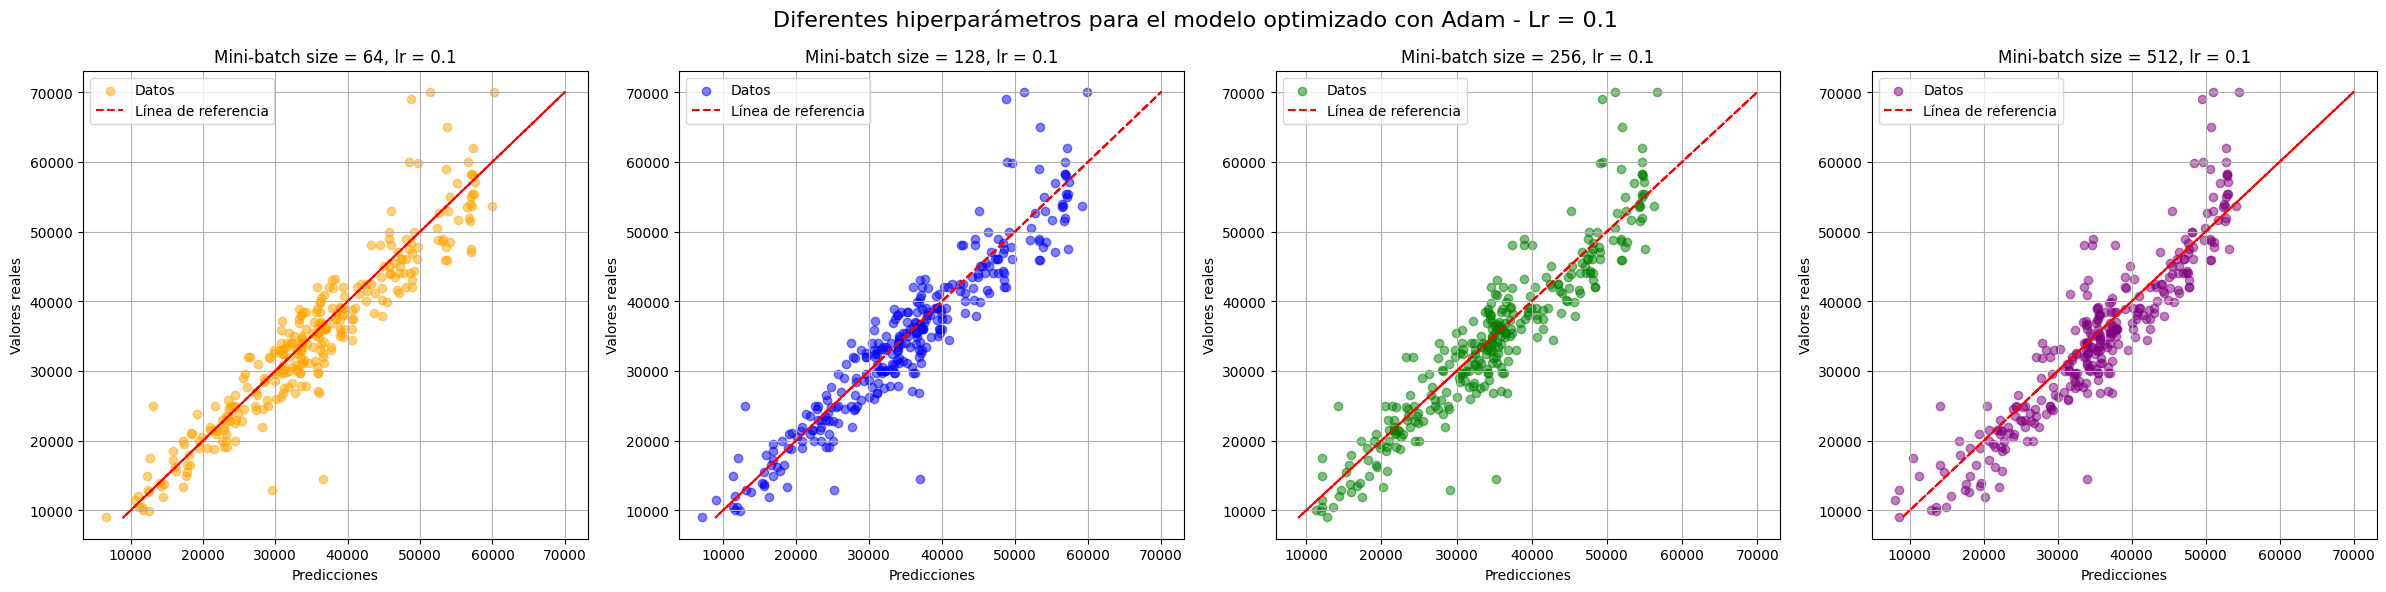

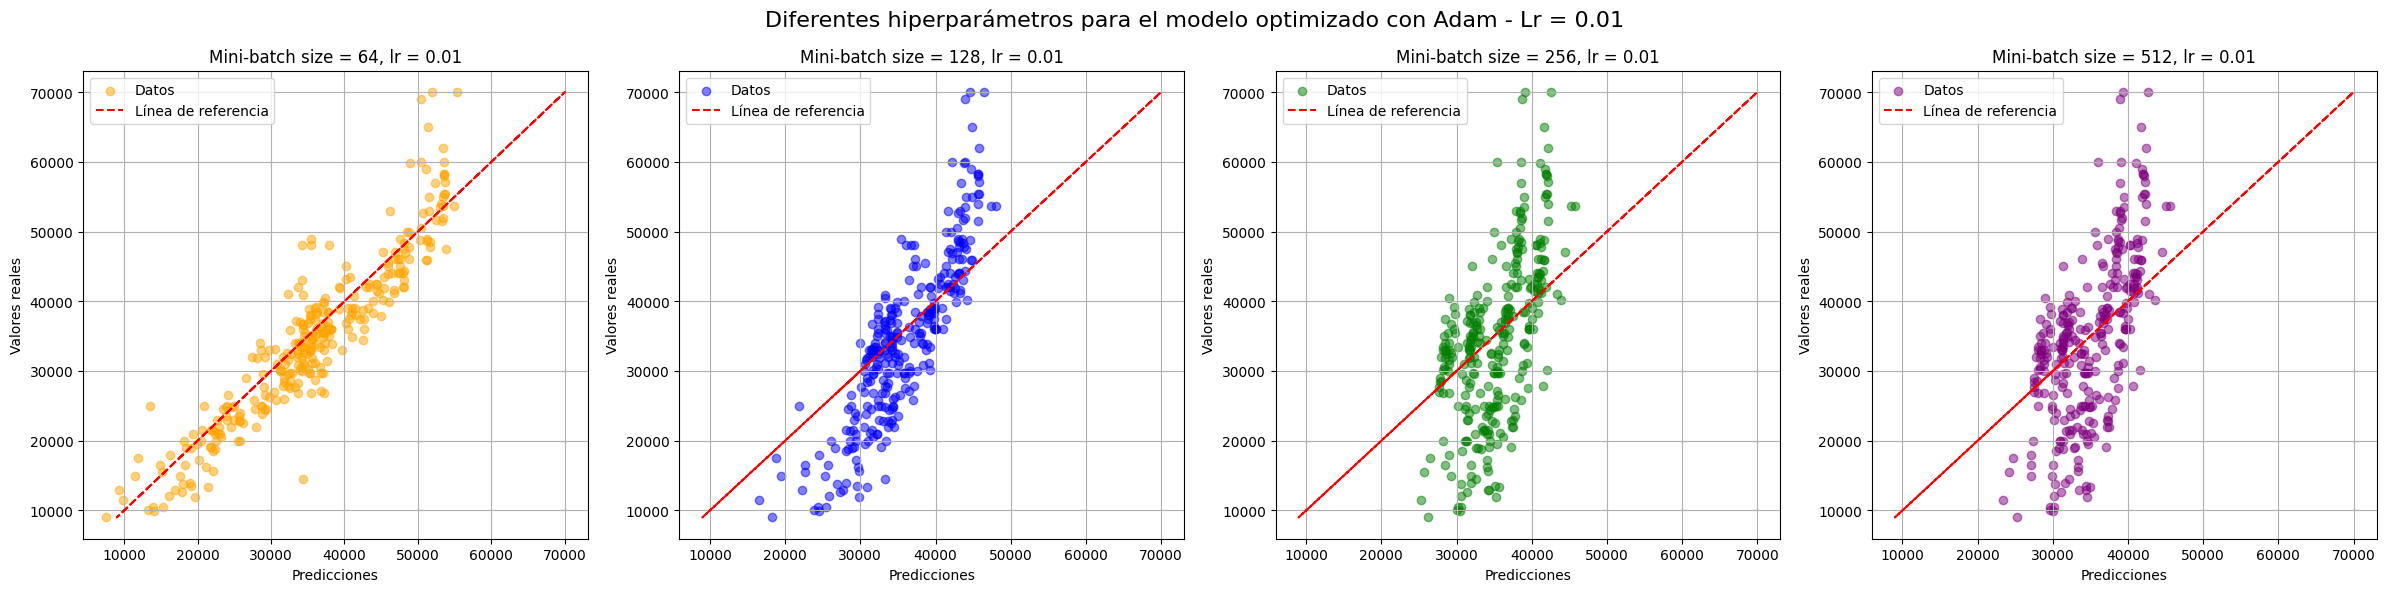

In [31]:
plt.figure(figsize=(24, 6))
plt.subplot(1, 4, 2)
plt.scatter(adam_predictions_3, y_val, color='blue', alpha=0.5)
plt.plot(y_val, y_val, color='red', linestyle='--')
plt.xlabel('Predicciones')
plt.ylabel('Valores reales')
plt.title('Mini-batch size = 128, lr = 0.1')
plt.grid(True)
plt.legend(['Datos', 'Línea de referencia'])
plt.subplot(1, 4, 3)
plt.scatter(adam_predictions_5, y_val, color='green', alpha=0.5)
plt.plot(y_val, y_val, color='red', linestyle='--')
plt.xlabel('Predicciones')
plt.ylabel('Valores reales')
plt.title('Mini-batch size = 256, lr = 0.1')
plt.grid(True)
plt.legend(['Datos', 'Línea de referencia'])
plt.subplot(1, 4, 4)
plt.scatter(adam_predictions_7, y_val, color='purple', alpha=0.5)
plt.plot(y_val, y_val, color='red', linestyle='--')
plt.xlabel('Predicciones')
plt.ylabel('Valores reales')
plt.title('Mini-batch size = 512, lr = 0.1')
plt.grid(True)
plt.legend(['Datos', 'Línea de referencia'])
plt.subplot(1, 4, 1)
plt.scatter(adam_predictions_1, y_val, color='orange', alpha=0.5)
plt.plot(y_val, y_val, color='red', linestyle='--')
plt.xlabel('Predicciones')
plt.ylabel('Valores reales')
plt.title('Mini-batch size = 64, lr = 0.1')
plt.grid(True)
plt.legend(['Datos', 'Línea de referencia'])
plt.suptitle('Diferentes hiperparámetros para el modelo optimizado con Adam - Lr = 0.1', fontsize=16)
plt.tight_layout()
plt.show()

plt.figure(figsize=(24, 6))
plt.subplot(1, 4, 2)
plt.scatter(adam_predictions_4, y_val, color='blue', alpha=0.5)
plt.plot(y_val, y_val, color='red', linestyle='--')
plt.xlabel('Predicciones')
plt.ylabel('Valores reales')
plt.title('Mini-batch size = 128, lr = 0.01')
plt.grid(True)
plt.legend(['Datos', 'Línea de referencia'])
plt.subplot(1, 4, 3)
plt.scatter(adam_predictions_6, y_val, color='green', alpha=0.5)
plt.plot(y_val, y_val, color='red', linestyle='--')
plt.xlabel('Predicciones')
plt.ylabel('Valores reales')
plt.title('Mini-batch size = 256, lr = 0.01')
plt.grid(True)
plt.legend(['Datos', 'Línea de referencia'])
plt.subplot(1, 4, 4)
plt.scatter(adam_predictions_8, y_val, color='purple', alpha=0.5)
plt.plot(y_val, y_val, color='red', linestyle='--')
plt.xlabel('Predicciones')
plt.ylabel('Valores reales')
plt.title('Mini-batch size = 512, lr = 0.01')
plt.grid(True)
plt.legend(['Datos', 'Línea de referencia'])
plt.subplot(1, 4, 1)
plt.scatter(adam_predictions_2, y_val, color='orange', alpha=0.5)
plt.plot(y_val, y_val, color='red', linestyle='--')
plt.xlabel('Predicciones')
plt.ylabel('Valores reales')
plt.title('Mini-batch size = 64, lr = 0.01')
plt.grid(True)
plt.legend(['Datos', 'Línea de referencia'])



plt.suptitle('Diferentes hiperparámetros para el modelo optimizado con Adam - Lr = 0.01', fontsize=16)
plt.tight_layout()
plt.show()

#### Es posible visualizar como los modelos con adam que mejor predicen son los que tienen el tamaño del mini-batch entre 64 y 256 con learning rate igual a 0.1.

---
# Ejercicio 5
### seleccionar los hiperparámetros $L$ y $M^{(l)}$ óptimos para la red neuronal

##### Para encontrar la mejor estructura para la red neuronal se intentó calcular las validation losses promedio de diferentes modelos del mejor encontrado (el optimizado con adam) entrenados con con K-folds (k=5). 

##### Las estructuras sin capas oscultas, es decir solo con capa de entrada y salida dan pérdidas altísimas, las más altas de todo el análisis (>1000 millones), y por ende fueron descartadas. Luego, con redes de una sola capa oculta se encontraron pérdidas no tan altas como las anteriories, pero de igual manera elevadas (mucha varianza, hasta 100 millones). 

##### A partir de ls 2 capas ocultas los rangos en los que aparecen las pérdidas de validación son las mismas (≈ 20 millones); es por eso que se realizó una selección entre las mejores arquitecturas (con las pérdidas más bajas en la mayoría de los casos) para determinar cual es la mejor. En caso de tener métricas parecidas, se escoge la que menor compljidad tenga. Dado a que la pérdida promedio es más alta a partir de las 4 capas ocultas estas se descartan por complegidad; entonces el análisis fue entre 2 y 3 capas ocultas. 

##### Tras realizar varias pruebas, las mejores arquitecturas terminaron siendo:

In [53]:
k = 5
arquitecturas = [
    [X.shape[1], 10, 12, 1], 
    [X.shape[1], 16, 32, 1], 
    [X.shape[1], 9, 13, 1], 
    [X.shape[1], 18, 12, 1], 
    [X.shape[1], 10, 12, 14, 1], 
    [X.shape[1], 16, 32, 64, 1], 
    [X.shape[1], 10, 12, 8, 1],
    [X.shape[1], 10, 8, 4, 1], 
    [X.shape[1], 16, 32, 24, 1], 
    [X.shape[1], 10, 12, 32, 1], 
]

folds = split_k_folds(training_data, k)
resultados_architecturas = {}
historico_val_losses = {} 

for arquitectura in arquitecturas:
    print(f"Evaluando arquitectura: {arquitectura}")
    
    val_losses_folds = [] 
    all_val_losses = [] 
    for i in range(k):
        validation_data = folds[i]
        training_data = [item for s, fold in enumerate(folds) if s != i for item in fold]
        mlp = MLP_OPT(layers=arquitectura, activations=['relu']*(len(arquitectura)-1), verbose=False, plot=False)
        _, val_losses = mlp.fit(training_data, epochs=100, mini_batch_size=64, lr=0.1, optimizer="adam", val_data=validation_data, verbose=3)
        val_losses_folds.append(val_losses[-1])  
        all_val_losses.append(val_losses)    
    avg_val_loss = np.mean(val_losses_folds)
    print(f"Pérdida promedio para arquitectura {arquitectura}: {avg_val_loss}")
    resultados_architecturas[tuple(arquitectura)] = avg_val_loss
    historico_val_losses[tuple(arquitectura)] = all_val_losses 

Evaluando arquitectura: [8, 10, 12, 1]
Pérdida promedio para arquitectura [8, 10, 12, 1]: 26730448.127594426
Evaluando arquitectura: [8, 16, 32, 1]
Pérdida promedio para arquitectura [8, 16, 32, 1]: 24950807.46352785
Evaluando arquitectura: [8, 9, 13, 1]
Pérdida promedio para arquitectura [8, 9, 13, 1]: 27416173.2397966
Evaluando arquitectura: [8, 18, 12, 1]
Pérdida promedio para arquitectura [8, 18, 12, 1]: 27046856.402975988
Evaluando arquitectura: [8, 10, 12, 14, 1]
Pérdida promedio para arquitectura [8, 10, 12, 14, 1]: 27017097.06905654
Evaluando arquitectura: [8, 16, 32, 64, 1]
Pérdida promedio para arquitectura [8, 16, 32, 64, 1]: 25537589.08578429
Evaluando arquitectura: [8, 10, 12, 8, 1]
Pérdida promedio para arquitectura [8, 10, 12, 8, 1]: 26078305.648953754
Evaluando arquitectura: [8, 10, 8, 4, 1]
Pérdida promedio para arquitectura [8, 10, 8, 4, 1]: 294762580.145996
Evaluando arquitectura: [8, 16, 32, 24, 1]
Pérdida promedio para arquitectura [8, 16, 32, 24, 1]: 24497240.5055

#### Dada a la poca diferencia relativa entre la mejor arquitectura globa y una menos compleja se determina como mejor arquitectura la que se compone por 2 capas ocultas ($L=2$) en las cuales $M^{(1)}=16$ y  $M^{(2)}=32$.

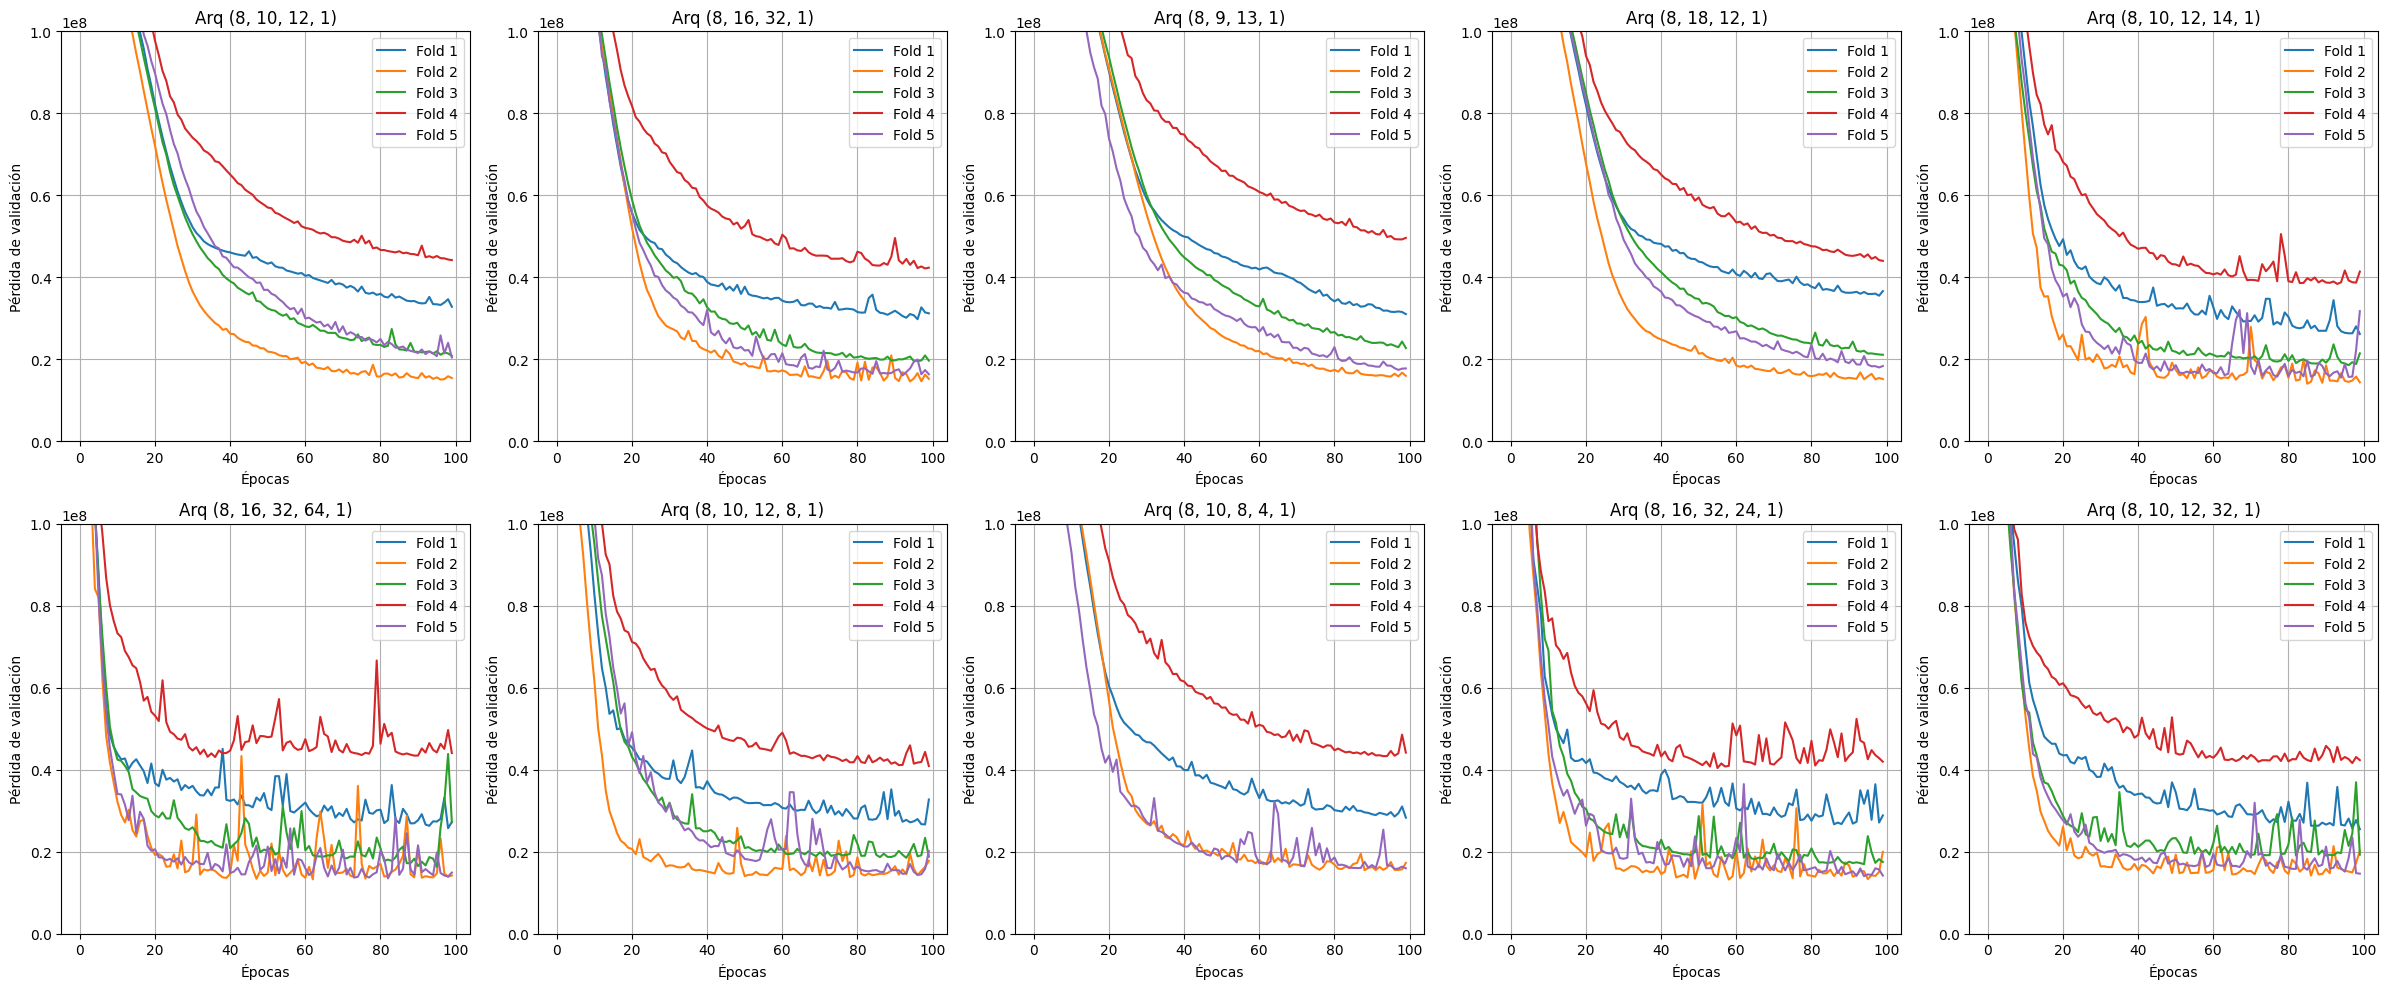

In [55]:
nrows, ncols = 2, 5 
fig, axs = plt.subplots(nrows, ncols, figsize=(24, 10))  
axs = axs.ravel()  
for idx, (arquitectura, val_losses_list) in enumerate(historico_val_losses.items()):
    ax = axs[idx] 
    for fold_idx, val_losses in enumerate(val_losses_list):
        ax.plot(val_losses, label=f'Fold {fold_idx + 1}') 
    ax.set_title(f'Arq {arquitectura}')
    ax.set_xlabel('Épocas')
    ax.set_ylabel('Pérdida de validación')
    ax.set_ylim([0, 1e8])
    ax.grid(True)
    ax.legend()
plt.tight_layout()
plt.show()

#### Aquí se puede observar como cuando la red es más compleja, tiende a tener más varianza, lo cual hace que el error predictivo sea mayor. También es posible ver como la arquitectura seleccionada es la que menor pérdida tiene en el k-fold porque tiene 3 de 5 folds muy bajos y bastante parecidos. 

---
# Ejercicio 6
### Evaluar las performances

## A) Con datos “held out” de los folds utilizados en la validación cruzada

In [58]:
mejor_modelo = [X.shape[1], 16, 32, 1]
k = 5
folds = split_k_folds(list(training_data), k) 
rmse_folds = []
mae_folds = []
r2_folds = []

for i in range(k):
    validation_data = folds[i]
    training_data = [item for s, fold in enumerate(folds) if s != i for item in fold]
    X_val = np.array([x for x, _ in validation_data])
    y_val = np.array([y for _, y in validation_data])
    mlp = MLP_OPT(layers=mejor_modelo, activations=['relu']*(len(mejor_modelo)-1), verbose=False, plot=False)
    mlp.fit(training_data, epochs=100, mini_batch_size=64, lr=0.1, optimizer="adam", val_data=validation_data, verbose=0)
    y_pred = (mlp.predict(X_val)).flatten()
    
    rmse_folds.append(rmse(y_val, y_pred))
    mae_folds.append(mae(y_val, y_pred))
    r2_folds.append(r2(y_val, y_pred))

rmsecv = np.mean(rmse_folds)
maecv = np.mean(mae_folds)
r2cv = np.mean(r2_folds)
print(f"RMSE-CV: {rmsecv}")
print(f"MAE-CV: {maecv}")
print(f"R2-CV: {r2cv}")


Training Epochs: 100%|██████████| 100/100 [00:03<00:00, 28.57it/s]

RMSE-CV: 5564.847988783633
MAE-CV: 3464.3417621299463
R2-CV: 0.8199727290451306


El modelo tiene una buena performance al predecir sobre el set de validación dentro del set de desarrollo.

## B) Con el set de prueba/test

In [65]:
archivo = '../data/raw/toyota_test.csv'
data = pd.read_csv(archivo)
raw_data = data.drop(columns=['id'])
raw_data = data.drop(columns=['Color'])
datos_curados = handle_missing_values(raw_data)
X = datos_curados.iloc[:, :-1]  
y = datos_curados.iloc[:, -1]  
X = numerize(X)
X = normalize(X)
testing_data = pd.concat([X, y], axis=1)
X_test= testing_data.iloc[:, :-1].values
y_test = testing_data.iloc[:, -1].values

In [67]:
mlp = MLP_OPT(layers=[X.shape[1], 16, 32, 1], activations=['relu', 'relu', 'relu'], verbose=False, plot=False)
mlp.fit(training_data, epochs=100, mini_batch_size=64, lr=0.1, optimizer="adam", val_data=validation_data, verbose=0)
y_pred = (mlp.predict(X_test)).flatten()
rmse_test = rmse(y_test, y_pred)
mae_test = mae(y_test, y_pred)
r2_test = r2(y_test, y_pred)
print(f"RMSE - Test: {rmse_test}")
print(f"MAE - Test: {mae_test}")
print(f"R2 - Test: {r2_test}")


Training Epochs: 100%|██████████| 100/100 [00:00<00:00, 101.01it/s]

RMSE - Test: 7125.780836798602
MAE - Test: 5419.464290275108
R2 - Test: 0.6548504087849392


#### Esta performance no es tan buena como la del set held-out del set de desarrollo, pero al ser datos completamente nuevos para el modelo, estas siguen siendo buenas métricas.

## C) Histograma de residuos absolutos

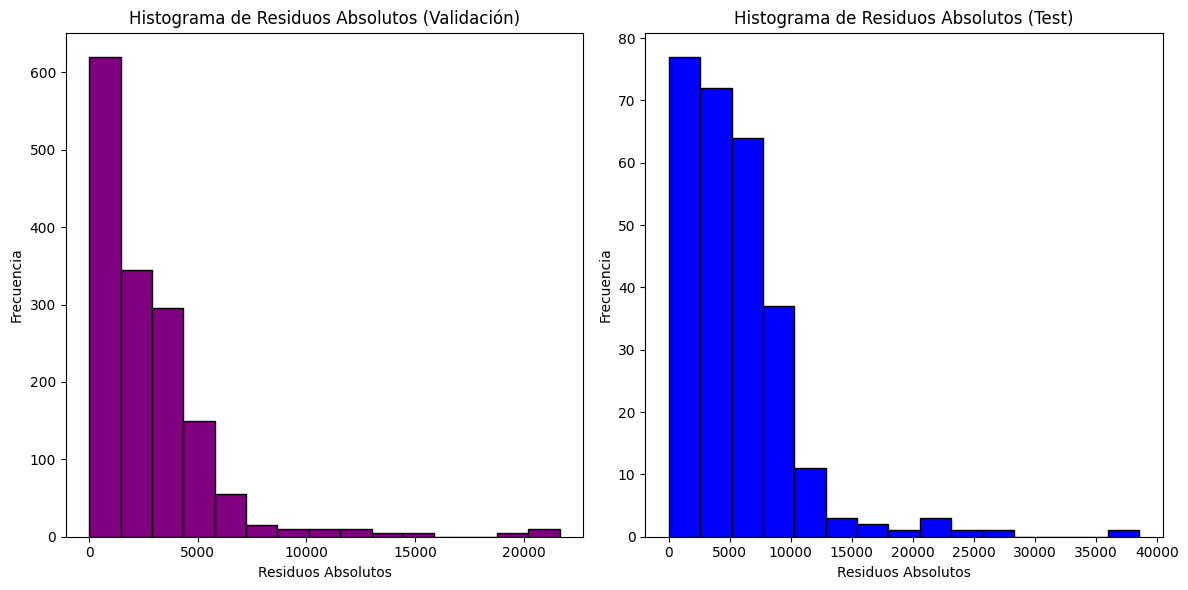

In [102]:
residuos_cv = []
for i in range(k):
    validation_data = folds[i]
    y_pred_val = (mlp.predict(X_val)).flatten()
    residuos_cv_fold = np.abs(y_val - y_pred_val)
    residuos_cv.extend(residuos_cv_fold)

residuos_test = np.abs(y_test - y_pred)
bins = 15

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)  # Primer gráfico
plt.hist(residuos_cv, bins=bins, color='purple', edgecolor='black')
plt.title('Histograma de Residuos Absolutos (Validación)')
plt.xlabel('Residuos Absolutos')
plt.ylabel('Frecuencia')
plt.subplot(1, 2, 2)  # Segundo gráfico
plt.hist(residuos_test, bins=bins, color='blue', edgecolor='black')
plt.title('Histograma de Residuos Absolutos (Test)')
plt.xlabel('Residuos Absolutos')
plt.ylabel('Frecuencia')
plt.tight_layout()
plt.show()


#### Es posible ver la tendencia, como también que los residuos para el set de prueba son mucho mayores ya que este es desconocido para el modelo.

## D) Diagrama de dispersión de las predicciones

In [99]:
mlp = MLP_OPT(layers=[X.shape[1], 16, 32, 1], activations=['relu', 'relu', 'relu'], verbose=False, plot=False)
mlp.fit(training_data, epochs=100, mini_batch_size=64, lr=0.1, optimizer="adam", verbose=0)
y_pred_ho = mlp.predict(X_val)

Training Epochs: 100%|██████████| 100/100 [00:12<00:00,  8.10it/s]


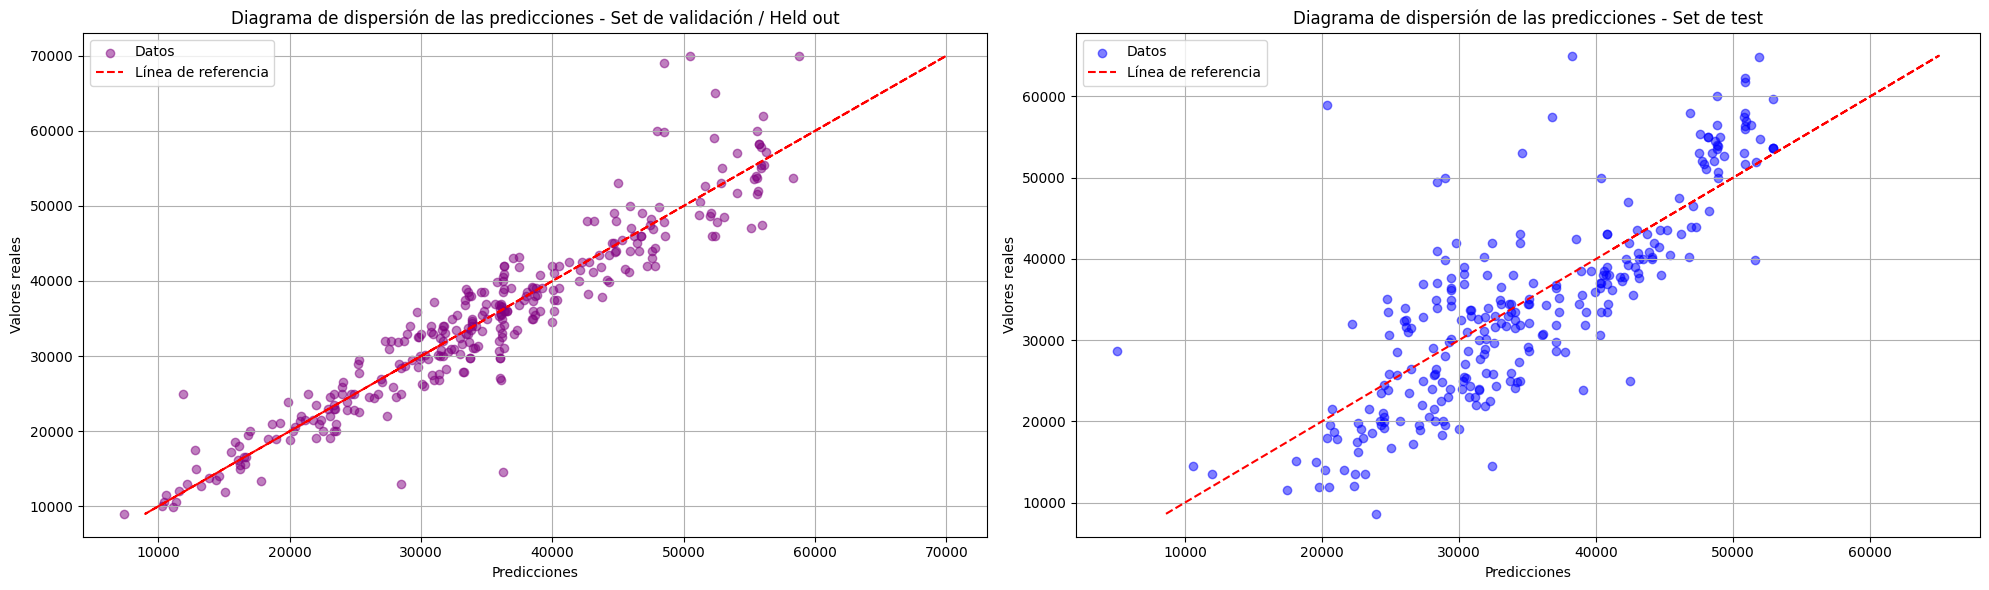

In [100]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))

ax1.scatter(y_pred_ho, y_val, color='purple', alpha=0.5)
ax1.plot(y_val, y_val, color='red', linestyle='--')
ax1.set_xlabel('Predicciones')
ax1.set_ylabel('Valores reales')
ax1.set_title('Diagrama de dispersión de las predicciones - Set de validación / Held out')
ax1.grid(True)
ax1.legend(['Datos', 'Línea de referencia'])
ax2.scatter(y_pred, y_test, color='blue', alpha=0.5)
ax2.plot(y_test, y_test, color='red', linestyle='--')
ax2.set_xlabel('Predicciones')
ax2.set_ylabel('Valores reales')
ax2.set_title('Diagrama de dispersión de las predicciones - Set de test')
ax2.grid(True)
ax2.legend(['Datos', 'Línea de referencia'])

plt.tight_layout()
plt.show()

## E) Probar con los modelos de regresión del TP2

In [13]:
model = RidgeRegression(lambda_=0.1)
model.fit(X_train, y_train)
y_pred = model.predict(X_val)
y_pred_RR = np.abs(y_pred)
rmse_rr = rmse(y_val, y_pred_RR)
mae_rr = mae(y_val, y_pred_RR)
r2_rr = r2(y_val, y_pred_RR)

model = LocallyWeightedRegression(tau=0.7)
model.fit(X_train, y_train)
y_predi = model.predict(X_val)
y_pred_LWR  = np.abs(y_predi)
rmse_lwr = rmse(y_val, y_pred_LWR)
mae_lwr = mae(y_val, y_pred_LWR)
r2_lwr = r2(y_val, y_pred_LWR)

model = NonLinearRegression(degree=2)
model.fit(X_train, y_train)
y_pred = model.predict(X_val)
y_pred_NLR  = np.abs(y_pred)
rmse_NLR = rmse(y_val, y_pred_NLR)
mae_NLR = mae(y_val, y_pred_NLR)
r2_NLR = r2(y_val, y_pred_NLR)

mlp = MLP_OPT(layers=[X.shape[1], 16, 32, 1], activations=['relu', 'relu', 'relu'], verbose=False, plot=False)
mlp.fit(training_data, epochs=100, mini_batch_size=64, lr=0.1, optimizer="adam", verbose=0)
y_pred_ho = (mlp.predict(X_val)).flatten()

Training Epochs: 100%|██████████| 100/100 [00:12<00:00,  8.25it/s]


             Modelo         RMSE          MAE        R2
0  Ridge Regression  4979.835059  3698.487343  0.825722
                       Modelo        RMSE          MAE        R2
0  Locally Wighted Regression  4662.45327  3556.905994  0.847229
                  Modelo         RMSE          MAE        R2
0  Non-Linear Regression  3879.395414  2866.358495  0.894235
           Modelo         RMSE          MAE        R2
0  Neural Network  3957.550037  2784.667508  0.889931


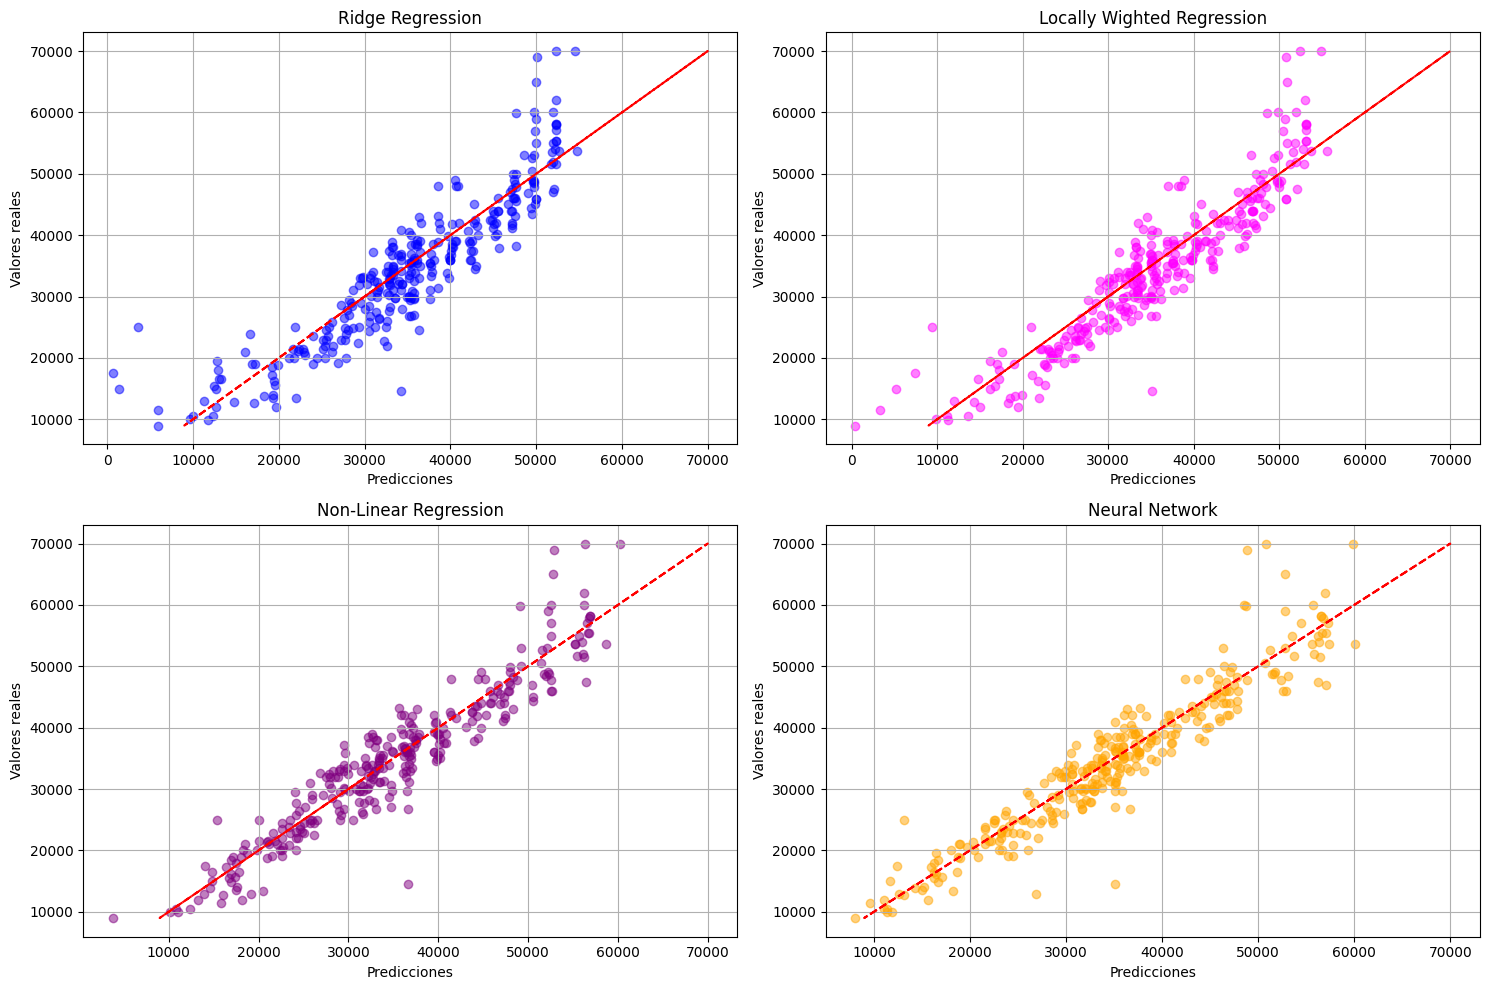

In [14]:
predictions = [y_pred_RR, y_pred_LWR, y_pred_NLR, y_pred_ho.flatten()]
titles = ['Ridge Regression', 'Locally Wighted Regression', 'Non-Linear Regression', 'Neural Network']
colors = ['blue', 'magenta', 'purple', 'orange']  
for i in range(len(predictions)):
    metrics_results = {        
        "Modelo":      titles[i],
        "RMSE":             rmse(y_val, (predictions[i])),
        "MAE":              mae(y_val, predictions[i]),
        "R2":               r2(y_val, predictions[i])
}
    metrics_df = pd.DataFrame(metrics_results, index=[0])
    print(metrics_df)

fig, axs = plt.subplots(2, 2, figsize=(15, 10))
for i, (ax, y_pred) in enumerate(zip(axs.flat, predictions)):
    ax.scatter(y_pred, y_val, alpha=0.5, color=colors[i])
    ax.plot(y_val, y_val, color='red', linestyle='--')
    ax.set_title(titles[i])
    ax.set_xlabel('Predicciones')
    ax.set_ylabel('Valores reales')
    ax.grid(True)
plt.tight_layout()
plt.show()

#### Según las métricas de performance los modelos de la red neuronal confeccionada en este trabajo y el de regresión no lineal son los mejores métodos, siendo el último ligeramente superior. Esto se puede deber a la naturaleza del problema o por la estructura más simple del modelo; el cual, con menor complejidad que una red neuronal, lorga encontrar relaciones no lineales entre los datos. 

---
# Ejercicio 7

In [4]:
import torch
import torch.nn as nn

#### Este modelo tiene las mismas epochs, betas para Adam (las básicas de pytorch), arquitectura de la red que nuestra red neuronal; pero variamos el learning rate.

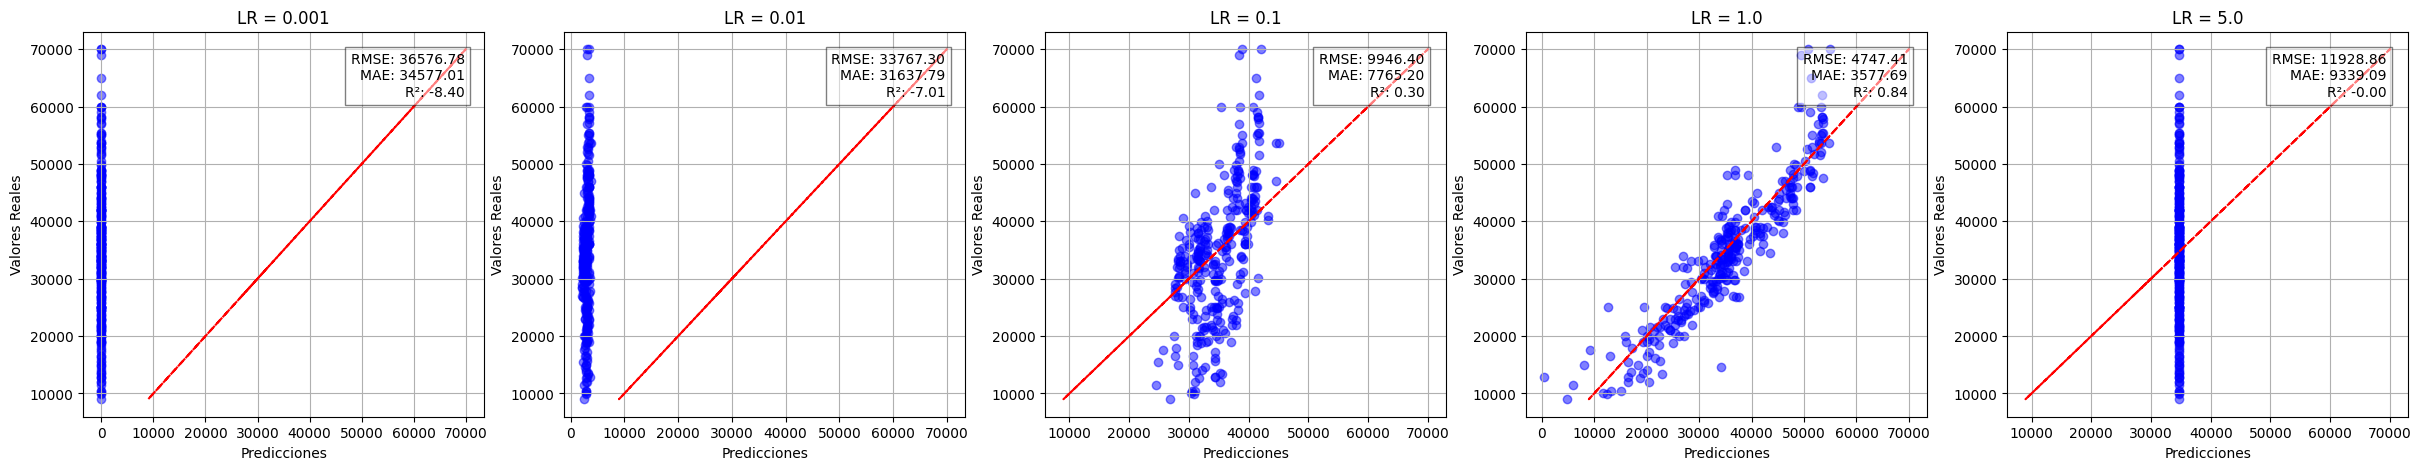

In [52]:
learning_rates = [0.001, 0.01, 0.1, 1.0, 5.0]
fig, axs = plt.subplots(1, len(learning_rates), figsize=(30, 5))

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_list = y_val.tolist() 

for i, lr in enumerate(learning_rates):
    model = nn.Sequential(
        nn.Linear(X_train.shape[1], 16),  
        nn.ReLU(),                       
        nn.Linear(16, 32),               
        nn.ReLU(),                 
        nn.Linear(32, 1)               
    )
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    epochs = 100
    for epoch in range(epochs):
        model.train()  
        predictions = model(X_train_tensor)
        loss = criterion(predictions, y_train_tensor)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    model.eval()
    with torch.no_grad():
        predictions_val = model(X_val_tensor)
    
    predictions_val_list = predictions_val.cpu().detach().view(-1).tolist()
    predictions_val_np = np.array(predictions_val_list)
    y_val_np = np.array(y_val_list)

    rmse_val = rmse(y_val_np, predictions_val_np)
    mae_val = mae(y_val_np, predictions_val_np)
    r2_val = r2(y_val_np, predictions_val_np)

    axs[i].scatter(predictions_val_list, y_val_list, color='blue', alpha=0.5)
    axs[i].plot(y_val_list, y_val_list, color='red', linestyle='--')
    axs[i].set_xlabel('Predicciones')
    axs[i].set_ylabel('Valores Reales')
    axs[i].set_title(f'LR = {lr}')
    axs[i].grid(True)
    metrics_text = f'RMSE: {rmse_val:.2f}\nMAE: {mae_val:.2f}\nR²: {r2_val:.2f}'

    x_pos = axs[i].get_xlim()[1] * 0.95  
    y_pos = axs[i].get_ylim()[1] * 0.95
    axs[i].text(x_pos, y_pos, metrics_text, fontsize=10, color='black', 
                ha='right', va='top', bbox=dict(facecolor='white', alpha=0.5))
plt.show()


#### En cuestiones de velocidad, este modelo es muchísimo más veloz que la red neuronal producida en este trabajo, pero las métricas de performance no son mejores; de hecho el valor de R2 es menor en el modelo de PyTorch, lo que quiere decir que nuestro modelo trabaja mejor con la varianza de datos, pudiendo predecirlos correctamente. 

#### También es posible ver como en este caso ocurre que el learning rate de 1.0 resulta ser el mejor hiperparámetro para el modelo.

### En conclusión, nuestro modelo es mejor, aún si temporalmente es peor, provee mejores resultados.